In [1]:
%%capture
%pip install numpyro==0.10.1
%pip install optax
%pip install -U jax jaxlib

In [2]:
! git clone https://github.com/rakoort99/TBIP_testing



Cloning into 'TBIP_testing'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 90 (delta 27), reused 70 (delta 20), pack-reused 0
Unpacking objects: 100% (90/90), 6.97 MiB | 4.98 MiB/s, done.


In [107]:
from jax import random

num_topics = 30
rng_seed = random.PRNGKey(0)

In [108]:
from scipy import sparse
import jax
import jax.numpy as jnp
import numpy as np

dataPath = "TBIP_testing/data/paradigms/clean/"

# Load data
author_indices = jax.device_put(
    jnp.load(dataPath + "author_indices.npy"), jax.devices("gpu")[0]
)

counts = sparse.load_npz(dataPath + "counts.npz")

with open(dataPath + "vocabulary.txt", "r") as f:
    vocabulary = f.readlines()

with open(dataPath + "author_map.txt", "r") as f:
    author_map = f.readlines()

author_map = np.array(author_map)

num_authors = int(author_indices.max() + 1)
num_documents, num_words = counts.shape

print('num_docs:', num_documents)
print('num_authors', num_authors)
print('dim authormap', author_map.shape)
print('dim author indices', author_indices.shape)


num_docs: 1806
num_authors 1816
dim authormap (1816,)
dim author indices (1806,)


In [109]:
pre_initialize_parameters = True

In [110]:
# Fit NMF to be used as initialization for TBIP
from sklearn.decomposition import NMF

if pre_initialize_parameters:
    nmf_model = NMF(
        n_components=num_topics, init="random", random_state=0, max_iter=500
    )
    # Define initialization arrays
    initial_document_loc = jnp.log(
        jnp.array(np.float32(nmf_model.fit_transform(counts) + 1e-2))
    )
    initial_objective_topic_loc = jnp.log(
        jnp.array(np.float32(nmf_model.components_ + 1e-2))
    )
else:
    rng1, rng2 = random.split(rng_seed, 2)
    initial_document_loc = random.normal(rng1, shape=(num_documents, num_topics))
    initial_objective_topic_loc = random.normal(rng2, shape=(num_topics, num_words))

In [111]:
from numpyro import plate, sample, param
import numpyro.distributions as dist
from numpyro.distributions import constraints

# Define the model and variational family


class TBIP:
    def __init__(self, N, D, K, V, batch_size, init_mu_theta=None, init_mu_beta=None):
        self.N = N  # number of people
        self.D = D  # number of documents
        self.K = K  # number of topics
        self.V = V  # number of words in vocabulary
        self.batch_size = batch_size  # number of documents in a batch

        if init_mu_theta is None:
            init_mu_theta = jnp.zeros([D, K])
        else:
            self.init_mu_theta = init_mu_theta

        if init_mu_beta is None:
            init_mu_beta = jnp.zeros([K, V])
        else:
            self.init_mu_beta = init_mu_beta

    def model(self, Y_batch, d_batch, i_batch):
        with plate("i", self.N):
            # Sample the per-unit latent variables (ideal points)
            x = sample("x", dist.Normal())

        with plate("k", size=self.K, dim=-2):
            with plate("k_v", size=self.V, dim=-1):
                beta = sample("beta", dist.Gamma(0.3, 0.3))
                eta = sample("eta", dist.Normal())

        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                # Sample document-level latent variables (topic intensities)
                theta = sample("theta", dist.Gamma(0.3, 0.3))

            # Compute Poisson rates for each word
            P = jnp.sum(
                jnp.expand_dims(theta, 2)
                * jnp.expand_dims(beta, 0)
                * jnp.exp(
                    jnp.expand_dims(x[i_batch], (1, 2)) * jnp.expand_dims(eta, 0)
                ),
                1,
            )

            with plate("v", size=self.V, dim=-1):
                # Sample observed words
                sample("Y_batch", dist.Poisson(P), obs=Y_batch)

    def guide(self, Y_batch, d_batch, i_batch):
        # This defines variational family. Notice that each of the latent variables
        # defined in the sample statements in the model above has a corresponding
        # sample statement in the guide. The guide is responsible for providing
        # variational parameters for each of these latent variables.

        # Also notice it is required that model and the guide have the same call.

        mu_x = param(
            "mu_x", init_value=-1 + 2 * random.uniform(random.PRNGKey(1), (self.N,))
        )
        sigma_x = param(
            "sigma_y", init_value=jnp.ones([self.N]), constraint=constraints.positive
        )

        mu_eta = param(
            "mu_eta", init_value=random.normal(random.PRNGKey(2), (self.K, self.V))
        )
        sigma_eta = param(
            "sigma_eta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )

        mu_theta = param("mu_theta", init_value=self.init_mu_theta)
        sigma_theta = param(
            "sigma_theta",
            init_value=jnp.ones([self.D, self.K]),
            constraint=constraints.positive,
        )

        mu_beta = param("mu_beta", init_value=self.init_mu_beta)
        sigma_beta = param(
            "sigma_beta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )

        with plate("i", self.N):
            sample("x", dist.Normal(mu_x, sigma_x))

        with plate("k", size=self.K, dim=-2):
            with plate("k_v", size=self.V, dim=-1):
                sample("beta", dist.LogNormal(mu_beta, sigma_beta))
                sample("eta", dist.Normal(mu_eta, sigma_eta))

        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                sample("theta", dist.LogNormal(mu_theta[d_batch], sigma_theta[d_batch]))

    def get_batch(self, rng, Y, author_indices):
        # Helper functions to obtain a batch of data, convert from scipy.sparse
        # to jax.numpy.array and move to gpu

        D_batch = random.choice(rng, jnp.arange(self.D), shape=(self.batch_size,))
        Y_batch = jax.device_put(jnp.array(Y[D_batch].toarray()), jax.devices("gpu")[0])
        D_batch = jax.device_put(D_batch, jax.devices("gpu")[0])
        I_batch = author_indices[D_batch]
        return Y_batch, I_batch, D_batch

In [112]:
from numpyro import plate, sample, param
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer.autoguide import AutoNormal
# Define the model and variational family


class TBIP:
    def __init__(self, N, D, K, V, batch_size, init_mu_theta=None, init_mu_beta=None):
        self.N = N  # number of people
        self.D = D  # number of documents
        self.K = K  # number of topics
        self.V = V  # number of words in vocabulary
        self.batch_size = batch_size  # number of documents in a batch

        if init_mu_theta is None:
            init_mu_theta = jnp.zeros([D, K])
        else:
            self.init_mu_theta = init_mu_theta

        if init_mu_beta is None:
            init_mu_beta = jnp.zeros([K, V])
        else:
            self.init_mu_beta = init_mu_beta

    def model(self, Y_batch, d_batch, i_batch):

        with plate("k", size=self.K, dim=-2):
            with plate("i_k", self.N, dim=-3):
                x = sample("x", dist.Normal())
            with plate("k_v", size=self.V, dim=-1):
                beta = sample("beta", dist.Gamma(0.3, 0.3))
                eta = sample("eta", dist.Normal())
        print("x shape:", x.shape)
        print("beta shape:", beta.shape)
        print("eta shape:", eta.shape)

        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                # Sample document-level latent variables (topic intensities)
                theta = sample("theta", dist.Gamma(0.3, 0.3))
            print("theta shape:", theta.shape)
            # Compute Poisson rates for each word

            P = jnp.sum(
                jnp.expand_dims(theta, 2)
                * jnp.expand_dims(beta, 0)
                * jnp.exp(
                    x[i_batch] * jnp.expand_dims(eta, 0)
                ),
                1,
            )
            print("p:", P.shape)
            with plate("v", size=self.V, dim=-1):
                # Sample observed words
                sample("Y_batch", dist.Poisson(P), obs=Y_batch)
        # print("theta shape:", theta.shape)

    def guide(self, Y_batch, d_batch, i_batch):
        # This defines variational family. Notice that each of the latent variables
        # defined in the sample statements in the model above has a corresponding
        # sample statement in the guide. The guide is responsible for providing
        # variational parameters for each of these latent variables.

        # Also notice it is required that model and the guide have the same call.
        # AutoNormal(model=self.model, init_loc_fn={"beta": self.init_mu_beta, "theta": self.init_mu_theta},
        #   )
        mu_x = param(
            "mu_x", init_value=-1 + 2 * random.uniform(random.PRNGKey(1), (self.N,self.K,1))
        )
        sigma_x = param(
            "sigma_y", init_value=jnp.ones([self.N,self.K,1]), constraint=constraints.positive
        )

        mu_eta = param(
            "mu_eta", init_value=random.normal(random.PRNGKey(2), (self.K, self.V))
        )
        sigma_eta = param(
            "sigma_eta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )

        mu_theta = param("mu_theta", init_value=self.init_mu_theta)
        sigma_theta = param(
            "sigma_theta",
            init_value=jnp.ones([self.D, self.K]),
            constraint=constraints.positive,
        )

        mu_beta = param("mu_beta", init_value=self.init_mu_beta)
        sigma_beta = param(
            "sigma_beta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )
        with plate("k", size=self.K, dim=-2):
            with plate("i_k", self.N, dim=-3):
                sample("x", dist.Normal(mu_x, sigma_x))

            with plate("k_v", size=self.V, dim=-1):
                sample("beta", dist.LogNormal(mu_beta, sigma_beta))
                sample("eta", dist.Normal(mu_eta, sigma_eta))


        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                # Sample document-level latent variables (topic intensities)
                sample("theta", dist.LogNormal(mu_theta[d_batch], sigma_theta[d_batch]))

    def get_batch(self, rng, Y, author_indices):
        # Helper functions to obtain a batch of data, convert from scipy.sparse
        # to jax.numpy.array and move to gpu

        D_batch = random.choice(rng, jnp.arange(self.D), shape=(self.batch_size,))
        Y_batch = jax.device_put(jnp.array(Y[D_batch].toarray()), jax.devices("gpu")[0])
        D_batch = jax.device_put(D_batch, jax.devices("gpu")[0])
        I_batch = author_indices[D_batch]
        return Y_batch, I_batch, D_batch

In [113]:
# Initialize the model
from optax import adam, exponential_decay
from numpyro.infer import SVI, TraceMeanField_ELBO
from jax import jit

num_steps = 50000
batch_size = 512  # Large batches are recommended
learning_rate = 0.01
decay_rate = 0.01

tbip = TBIP(
    N=num_authors,
    D=num_documents,
    K=num_topics,
    V=num_words,
    batch_size=batch_size,
    init_mu_theta=initial_document_loc,
    init_mu_beta=initial_objective_topic_loc,
)

svi_batch = SVI(
    model=tbip.model,
    guide=tbip.guide,
    optim=adam(exponential_decay(learning_rate, num_steps, decay_rate)),
    loss=TraceMeanField_ELBO(),
)

# Compile update function for faster training
svi_batch_update = jit(svi_batch.update)

# Get initial batch. This informs the dimension of arrays and ensures they are
# consistent with dimensions (N, D, K, V) defined above.
Y_batch, I_batch, D_batch = tbip.get_batch(random.PRNGKey(1), counts, author_indices)

# Initialize the parameters using initial batch
svi_state = svi_batch.init(
    random.PRNGKey(0), Y_batch=Y_batch, d_batch=D_batch, i_batch=I_batch
)

x shape: (1816, 30, 1)
beta shape: (30, 9752)
eta shape: (30, 9752)
theta shape: (512, 30)
p: (512, 9752)


In [114]:
# @title Run this cell to create helper function for printing topics


def get_topics(
    neutral_mean, negative_mean, positive_mean, vocabulary, print_to_terminal=True
):
    num_topics, num_words = neutral_mean.shape
    words_per_topic = 10
    top_neutral_words = np.argsort(-neutral_mean, axis=1)
    top_negative_words = np.argsort(-negative_mean, axis=1)
    top_positive_words = np.argsort(-positive_mean, axis=1)
    topic_strings = []
    for topic_idx in range(num_topics):
        neutral_start_string = "Neutral  {}:".format(topic_idx)
        neutral_row = [
            vocabulary[word] for word in top_neutral_words[topic_idx, :words_per_topic]
        ]
        neutral_row_string = ", ".join(neutral_row)
        neutral_string = " ".join([neutral_start_string, neutral_row_string])

        positive_start_string = "Positive {}:".format(topic_idx)
        positive_row = [
            vocabulary[word] for word in top_positive_words[topic_idx, :words_per_topic]
        ]
        positive_row_string = ", ".join(positive_row)
        positive_string = " ".join([positive_start_string, positive_row_string])

        negative_start_string = "Negative {}:".format(topic_idx)
        negative_row = [
            vocabulary[word] for word in top_negative_words[topic_idx, :words_per_topic]
        ]
        negative_row_string = ", ".join(negative_row)
        negative_string = " ".join([negative_start_string, negative_row_string])

        if print_to_terminal:
            topic_strings.append(negative_string)
            topic_strings.append(neutral_string)
            topic_strings.append(positive_string)
            topic_strings.append("==========")
        else:
            topic_strings.append(
                "  \n".join([negative_string, neutral_string, positive_string])
            )

    if print_to_terminal:
        all_topics = "{}\n".format(np.array(topic_strings))
    else:
        all_topics = np.array(topic_strings)
    return all_topics

In [115]:
# from numpyro import render_model
# Y_batch, I_batch, D_batch = tbip.get_batch(random.PRNGKey(1), counts, author_indices)
# render_model(tbip.model, (Y_batch, I_batch, D_batch))


In [116]:
# Run SVI
from tqdm import tqdm
import pandas as pd

print_steps = 100
print_intermediate_results = False

rngs = random.split(random.PRNGKey(2), num_steps)
losses = []
pbar = tqdm(range(num_steps))


for step in pbar:
    Y_batch, I_batch, D_batch = tbip.get_batch(rngs[step], counts, author_indices)
    svi_state, loss = svi_batch_update(
        svi_state, Y_batch=Y_batch, d_batch=D_batch, i_batch=I_batch
    )

    loss = loss / counts.shape[0]
    losses.append(loss)
    if step % print_steps == 0 or step == num_steps - 1:
        pbar.set_description(
            "Init loss: "
            + "{:10.4f}".format(jnp.array(losses[0]))
            + f"; Avg loss (last {print_steps} iter): "
            + "{:10.4f}".format(jnp.array(losses[-100:]).mean())
        )

    if (step + 1) % 2500 == 0 or step == num_steps - 1:
        # Save intermediate results
        estimated_params = svi_batch.get_params(svi_state)

        neutral_mean = (
            estimated_params["mu_beta"] + estimated_params["sigma_beta"] ** 2 / 2
        )

        positive_mean = (
            estimated_params["mu_beta"]
            + estimated_params["mu_eta"]
            + (estimated_params["sigma_beta"] ** 2 + estimated_params["sigma_eta"] ** 2)
            / 2
        )

        negative_mean = (
            estimated_params["mu_beta"]
            - estimated_params["mu_eta"]
            + (estimated_params["sigma_beta"] ** 2 + estimated_params["sigma_eta"] ** 2)
            / 2
        )

        np.save("neutral_topic_mean.npy", neutral_mean)
        np.save("negative_topic_mean.npy", positive_mean)
        np.save("positive_topic_mean.npy", negative_mean)

        topics = get_topics(neutral_mean, positive_mean, negative_mean, vocabulary)

        with open("topics.txt", "w") as f:
            print(topics, file=f)
        IP_dict = {}
        IP_dict["name"] = author_map
        for i in range(estimated_params["mu_x"].shape[1]):
            IP_dict[f'ideal_point_{i}'] = jnp.ravel(estimated_params["mu_x"][:,i,:])
        authors = pd.DataFrame(
            IP_dict
        )
        authors.to_csv("authors.csv")

        if print_intermediate_results:
            print(f"Results after {step} steps.")
            print(topics)
            sorted_authors = "Authors sorted by their ideal points: " + ",".join(
                list(authors.sort_values("ideal_point")["name"])
            )
            print(sorted_authors.replace("\n", " "))

  0%|          | 0/50000 [00:00<?, ?it/s]

x shape: (1816, 30, 1)
beta shape: (30, 9752)
eta shape: (30, 9752)
theta shape: (512, 30)
p: (512, 9752)


Init loss: 3033758.5000; Avg loss (last 100 iter):  1611.9231:   5%|▍         | 2498/50000 [00:55<16:34, 47.75it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/lax_numpy.py:3652: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "
Init loss: 3033758.5000; Avg loss (last 100 iter):   917.4506: 100%|██████████| 50000/50000 [17:47<00:00, 46.84it/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

neutral_topic_mean = np.load("neutral_topic_mean.npy")
negative_topic_mean = np.load("negative_topic_mean.npy")
positive_topic_mean = np.load("positive_topic_mean.npy")
authors = pd.read_csv("authors.csv")
authors["name"]

decoder = pd.read_csv(dataPath +'id_name_para.csv', index_col=0)['Judge Name']


In [ ]:
decoder

Judge ID
1              Chris Palmer
3               Aaron Hardy
319             Paul Wexler
1057          Shunta Jordan
1088            Bill Smelko
                ...        
508301            Elle Baez
512630         Andrew Leong
520399            Max Smith
523149    Emilio Matos-Sola
523323        Amber Benning
Name: Judge Name, Length: 1816, dtype: object

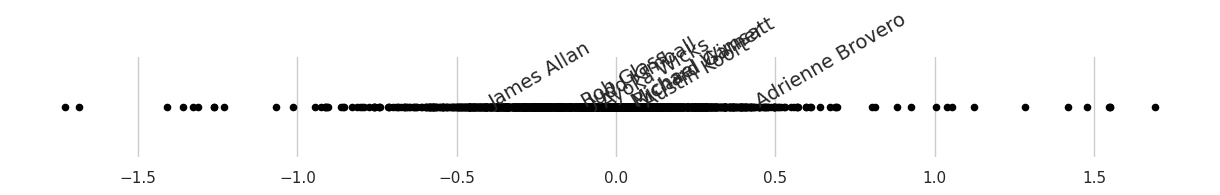

In [ ]:
selected_authors = np.array(
    [
        "Rob Glass",
        "James Allan",
        "Michael Wimsatt",
        "Richard Garner",
        "Austin Koort",
        "Adrienne Brovero",
        "Nyx Moore",
        "Judd Kimball",
        "Ayoka Wicks",
        "Morgan Copeland",
        "John Katsulas",
        "Samuel Maurer"
    ]
)

sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 1))
ax = plt.axes([0, 0, 1, 1], frameon=False)
for index in range(authors.shape[0]):
    ax.scatter(authors["ideal_point"][index], 0, c="black", s=20)
    if decoder[authors["name"][index]] in selected_authors:
        ax.annotate(
            decoder[authors["name"][index]],
            xy=(authors["ideal_point"][index], 0.0),
            xytext=(authors["ideal_point"][index], 0),
            rotation=30,
            size=14,
        )
ax.set_yticks([])
plt.show()



In [ ]:
get_topics(neutral_topic_mean, negative_topic_mean, positive_topic_mean, vocabulary)

"['Negative 0: decision\\n, speeches\\n, part\\n, clash\\n, right\\n, persuasive\\n, were\\n, ndt\\n, two\\n, made\\n'\n 'Neutral  0: activity\\n, decision\\n, community\\n, style\\n, line\\n, particular\\n, each\\n, issues\\n, role\\n, clarity\\n'\n 'Positive 0: particular\\n, activity\\n, traditional\\n, rounds\\n, studies\\n, style\\n, possible\\n, argumentation\\n, view\\n, education\\n'\n '=========='\n 'Negative 1: longer\\n, now\\n, thats\\n, actually\\n, dumb\\n, voted\\n, love\\n, might\\n, hate\\n, once\\n'\n 'Neutral  1: our\\n, now\\n, its\\n, us\\n, world\\n, life\\n, had\\n, words\\n, talk\\n, love\\n'\n 'Positive 1: he\\n, our\\n, his\\n, us\\n, through\\n, politics\\n, black\\n, usma\\n, military\\n, had\\n'\n '=========='\n 'Negative 2: speed\\n, rules\\n, parli\\n, nfa ld\\n, run\\n, fine\\n, rounds\\n, slow down\\n, opponent\\n, weighing\\n'\n 'Neutral  2: run\\n, speed\\n, performance\\n, open\\n, fun\\n, fine\\n, running\\n, rules\\n, end\\n, abuse\\n'\n 'Positive 